## Зачетная работа

Дла анализа вам предлагается набор данных об академической успеваемости учеников. Требуется построить модель, классифицирующую учеников по успеваемости.

Описание данных:
* _cat_ __Gender__: M -- male, F -- female
* _cat_ __Nationality__: национальность ученика
* _cat_ __PlaceofBirth__: место рождения ученика
* _cat_ __StageID__: уровень образования ученика
* _cat_ __GradeID__: номер класса
* _cat_ __SectionID__: номер секции
* _cat_ __Topic__: тема курса
* _cat_ __Semester__: номер семестра (F -- first, S -- second)
* _cat_ __Relation__: родитель, несущий ответственность за ученика
* _num_ __raisedhands__: количество поднятий руки на занятиях
* _num_ __VisITedResources__: количество посещений учеником информационных ресурсов по курсу
* _num_ __AnnouncementsView__: количество просмотров новых объявлений по курсу
* _num_ __Discussion__: количетсво участий в обсуждениях в группе
* _cat_ __ParentAnsweringSurvey__: проходили ли родители ученика опрос от школы ('Yes'/'No')
* _cat_ __ParentschoolSatisfaction__: степень удовлетворенности родителей школой ('Good'/'Bad')
* _cat_ __StudentAbsenceDays__: количество пропущенных учеником дней ('Under-7' -- менее 7, 'Above-7' -- более 7)
* __Class__: успеваемость (L -- low (от 0 до 69 баллов), M -- middle (от 70 до 89 баллов), H -- high (от 90 до 100 баллов))

### Требуется

1. Провести предварительную обработку данных.
2. Построить две модели классификации (см. список ниже), для каждой из которых:

    2.1. Выбрать параметр (параметры), который будете подбирать.

    2.2. Оценить качество по кросс-валидации в зависимости от значений параметра (параметров). В качестве метрики качества использовать Accuracy.
    
    2.3. Выбрать наилучший параметр (параметры).
    
3. Сравнить модели между собой, сделать выводы.

## Список моделей

1. Метод опорных векторов (sklearn.svm.SVC)
2. Метод k ближайших соседей (sklearn.neighbors.KNeighborsClassifier)
3. Решающее дерево (sklearn.tree.DecisionTreeClassifier)
4. Случайный лес (sklearn.ensemble.RandomForestClassifier)
5. Линейная модель классификации с L2 регуляризацией (sklearn.linear_model.RidgeClassifier)

* Пашков Андрей        1, 3

In [1]:
# !! Требуется модуль plotly !!
# conda install plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, fit_grid_point, ParameterGrid
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
from sklearn.metrics import accuracy_score

# def Scorer(estimator, X, y):
#     return accuracy_score(y, estimator.predict(X))

CV = 10
N_JOBS = -1
SCORING = 'accuracy'

Видим, что выборка мала и в ней нет пропущенных значений.
Среди 16 признаков всего 4 числовых.

In [3]:
data = pd.read_csv('education_data.csv')
cat_columns = [col for col in data.columns if data[col].dtype == object]
num_columns = [col for col in data.columns if data[col].dtype != object]
print(data.shape, data.dropna().shape)
print('Is null \n', data.all().isnull())
data.head(5)

(480, 17) (480, 17)
Is null 
 gender                      False
NationalITy                 False
PlaceofBirth                False
StageID                     False
GradeID                     False
SectionID                   False
Topic                       False
Semester                    False
Relation                    False
raisedhands                 False
VisITedResources            False
AnnouncementsView           False
Discussion                  False
ParentAnsweringSurvey       False
ParentschoolSatisfaction    False
StudentAbsenceDays          False
Class                       False
dtype: bool


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [4]:
"""
Encode categorial features to nums

Parametrs:
----------
data : DataFrame

Return:
-------
encoded dataframe
"""
def encode_data_for_visualisation(data, ordered):
    enc_data = data.copy()
    dict_uniqs = {}
    for col in data.columns:
        if data[col].dtype == object :
            uniq_vals = ordered[col] if col in ordered else data[col].unique()
            dict_uniqs[col] = uniq_vals
            uniq_to_num = dict(zip(uniq_vals, range(0, len(uniq_vals))))
            encode = lambda column : [uniq_to_num[v] for v in column]
            enc_data[col] = encode(data[col])
    return enc_data, dict_uniqs

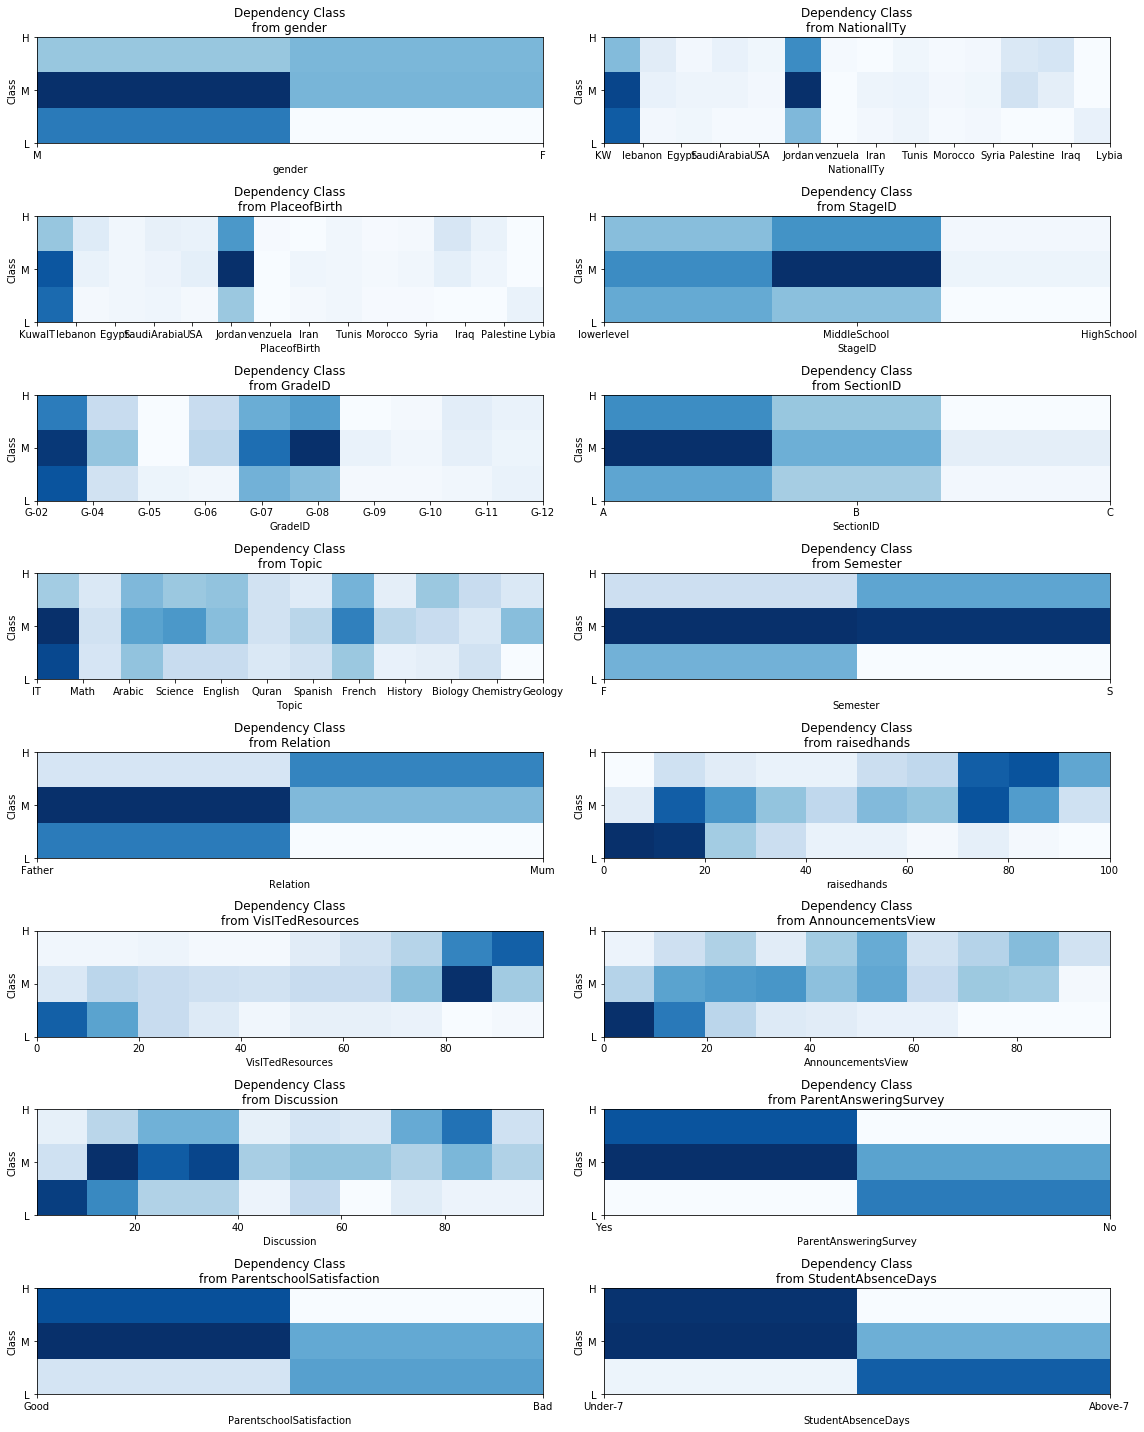

In [5]:
ordered = {'Class' : ['L', 'M', 'H'], 
           'GradeID' : ['G-02', 'G-04', 'G-05', 'G-06', 'G-07', 'G-08', 'G-09', 'G-10', 'G-11', 'G-12'] }
data_vis, dict_uniqs = encode_data_for_visualisation(data, ordered)
x_vis = data_vis.drop(['Class'], axis = 1)
y_vis = data_vis['Class']
nrows=8
ncols=2
fig, axes = plt.subplots(nrows, ncols, figsize = (16, 20))
for i, colX in enumerate(x_vis.columns):
    subplot = axes[i//ncols, i%ncols]
    bins = [len(dict_uniqs[colX]), len(dict_uniqs[y_vis.name])] if colX in dict_uniqs else [10, len(dict_uniqs[y_vis.name])]
    subplot.hist2d(x_vis[colX], y_vis, cmap="Blues", bins = bins)
    subplot.set_title("Dependency " + y_vis.name + "\nfrom " + colX)
    subplot.set_xlabel(colX)
    subplot.set_ylabel(y_vis.name)
    subplot.set_yticks(range(len(dict_uniqs[y_vis.name])))
    subplot.set_yticklabels(dict_uniqs[y_vis.name])
    if colX in dict_uniqs:
        subplot.set_xticks(range(len(dict_uniqs[colX])))
        subplot.set_xticklabels(dict_uniqs[colX])
plt.tight_layout()
plt.show()


In [6]:
data_vis.describe()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.364583,3.858333,3.510417,0.654167,2.906250,0.472917,4.402083,0.489583,0.410417,46.775000,54.797917,37.918750,43.283333,0.437500,0.391667,0.397917,1.031250
std,0.481815,3.848478,3.505423,0.603732,2.464267,0.612411,3.455472,0.500413,0.492423,30.779223,33.080007,26.611244,27.637735,0.496596,0.488632,0.489979,0.748738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,15.750000,20.000000,14.000000,20.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,4.500000,1.000000,4.000000,0.000000,4.000000,0.000000,0.000000,50.000000,65.000000,33.000000,39.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,5.000000,5.000000,1.000000,5.000000,1.000000,7.000000,1.000000,1.000000,75.000000,84.000000,58.000000,70.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,13.000000,13.000000,2.000000,9.000000,2.000000,11.000000,1.000000,1.000000,100.000000,99.000000,98.000000,99.000000,1.000000,1.000000,1.000000,2.000000


In [7]:
data_vis.corr()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
gender,1.000000,-0.008116,0.014434,-0.017793,-0.016869,-0.054907,0.071017,-0.049156,0.195142,0.149978,0.210932,0.052139,0.124703,-0.022359,-0.093478,-0.209011,0.263490
NationalITy,-0.008116,1.000000,0.906489,-0.084926,-0.098262,-0.122099,0.463798,0.118477,0.213616,0.283838,0.292869,0.298792,0.001144,-0.064723,-0.261299,-0.080756,0.185566
PlaceofBirth,0.014434,0.906489,1.000000,-0.075238,-0.082903,-0.147685,0.486117,0.114315,0.243640,0.227106,0.284700,0.289818,0.011261,-0.075780,-0.241277,-0.056507,0.180037
StageID,-0.017793,-0.084926,-0.075238,1.000000,0.961835,-0.296416,0.148853,0.029512,-0.034205,0.172751,0.068621,0.163666,0.161406,-0.114025,0.014272,-0.112536,0.083997
GradeID,-0.016869,-0.098262,-0.082903,0.961835,1.000000,-0.303949,0.218961,0.066079,-0.033602,0.182621,0.078262,0.183033,0.168462,-0.118246,0.018421,-0.088342,0.067217
SectionID,-0.054907,-0.122099,-0.147685,-0.296416,-0.303949,1.000000,-0.224213,0.046763,0.005783,-0.143862,-0.080909,-0.144955,-0.102538,0.018449,0.070405,-0.037062,-0.036850
Topic,0.071017,0.463798,0.486117,0.148853,0.218961,-0.224213,1.000000,0.279511,0.241447,0.304377,0.378792,0.334392,-0.023449,-0.054063,-0.165179,-0.098395,0.165392
Semester,-0.049156,0.118477,0.114315,0.029512,0.066079,0.046763,0.279511,1.000000,0.148705,0.178358,0.173219,0.287066,0.019083,-0.023628,0.025258,-0.072462,0.126239
Relation,0.195142,0.213616,0.243640,-0.034205,-0.033602,0.005783,0.241447,0.148705,1.000000,0.364237,0.360240,0.339505,0.026720,-0.163811,-0.287698,-0.219687,0.401142
raisedhands,0.149978,0.283838,0.227106,0.172751,0.182621,-0.143862,0.304377,0.178358,0.364237,1.000000,0.691572,0.643918,0.339386,-0.316570,-0.297015,-0.463882,0.646298


# Обработка признаков

In [8]:
"""
Apply scaler to numeric data and combine with categorial data

Parametrs:
----------
scaler : Scaler with fit() & transfrom()
num_columns : columns names with numeric data
"""
class ScalerCombiner:
    def __init__(self, scaler, num_columns):
        self.scaler = scaler
        self.num_columns = num_columns
        
    def fit(self, X):
        self.scaler.fit(X[self.num_columns])
        return self
    
    def transform(self, X):
        X[self.num_columns] = self.scaler.transform(X[self.num_columns])

one-hot

In [9]:
x_cat = pd.get_dummies(data[list(set(cat_columns) - set(['Class']))], drop_first=True) # дропаем избыточную информацию
x_num = data[num_columns]
x = pd.concat([x_num, x_cat], axis = 1)
y = data.Class
x.shape

(480, 60)

In [10]:
from sklearn.model_selection import train_test_split
test_size = 0.3
rand_state = 0

__Raw data__

In [11]:
def split_raw():
    return train_test_split(x, y, test_size = test_size, random_state = rand_state)

Xy_raw = (x_train_raw, x_test_raw, 
 y_train_raw, y_test_raw) = split_raw()

__Startify data__

In [12]:
def split_strat():
    return train_test_split(x, y, test_size = test_size, random_state = rand_state, stratify = y)

Xy_strat = (x_train_strat, x_test_strat, 
 y_train_strat, y_test_strat) = split_strat()

In [17]:
import plotly.plotly as py
import plotly.graph_objs as go

def plot_init(x_ticks, typ, score):
    trace = go.Scatter(
        x = [x_ticks[0], x_ticks[-1]],
        y = [score]*2,
        name = typ,
        line = dict(
            #color = 'rgb(0, 0, 0)',
            width = 2,
            dash = 'dash')
    )
    return trace

def plot_test(x_ticks, scores):
    trace = go.Scatter( 
        x = x_ticks,
        y = scores,
        name = 'test',
        line = dict(
            color = 'rgb(100, 100, 100)',
            width = 2,
            dash = 'dot')
    )
    return trace

def plot_mean(gs, x_ticks, mean_type):
    mean_score = gs.cv_results_['mean_train_score'] if mean_type == 'train' else gs.cv_results_['mean_test_score']
    mean_trace = go.Scatter(
        x = x_ticks,
        y = mean_score,
        name = 'mean_train_CV' if mean_type == 'train' else 'mean_test_CV',
        line = dict(
            color = 'rgb(0, 0, 255)' if mean_type == 'train' else 'rgb(255, 0, 0)')
    )
    return mean_trace

"""
std_type = {train, test}
"""
def plot_std(gs, x_ticks, std_type):
    std_score = gs.cv_results_['std_train_score'] if std_type == 'train' else gs.cv_results_['std_test_score']
    mean_score = gs.cv_results_['mean_train_score'] if std_type == 'train' else gs.cv_results_['mean_test_score']
    std_score = (mean_score - std_score).tolist() + (mean_score + std_score).tolist()[::-1]
    std_trace = go.Scatter(
        x = x_ticks + x_ticks[::-1],
        y = std_score,
        #name = 'mean + std train' if std_type == 'train' else 'mean + std test',
        showlegend = False,
        #hoverinfo = 'none',
        fill='tozerox',
        fillcolor = 'rgba(0, 0, 155, 0.2)' if std_type == 'train' else 'rgba(155, 0, 0, 0.2)',
        line = dict(
            color = 'transparent')
    )
    return std_trace

def plot_grid_best(gs):
    trace = go.Scatter(
        x = [unpack(gs.best_params_)],
        y = [gs.best_score_],
        mode = 'markers',
        name = 'CV best',
        marker = dict(size = 11)
    )
    return trace
"""
dic = {name : score}
"""
def plot_grid_curves(grid_search, test_scores = None, dic = None):
    gs = grid_search
    data = [] 
    length = len(gs.cv_results_['params'])
    
    x_ticks = []
    for d in list(gs.cv_results_['params']):
         x_ticks.append(unpack(d))
    
    data.append(plot_mean(gs, x_ticks, 'train'))
    data.append(plot_std(gs, x_ticks, 'train'))
    data.append(plot_mean(gs, x_ticks, 'test'))
    data.append(plot_std(gs, x_ticks, 'test'))
    
    data.append(plot_grid_best(gs))
    data.append(plot_test(x_ticks, test_scores)) if test_scores is not None else ''
    
    if dic is not None:
        for k,v in dic.items():
            data.append(plot_init(x_ticks, k, v))# must be in the end

    layout = dict(title = 'CV scores',
                  xaxis = dict(title = 'Parametrs', tickfont = dict(size = 9.5)),
                  yaxis = dict(title = 'Accuracy score'))

    return dict(data=data, layout=layout)


# for params in gs.cv_results_['params']:
#     fit_grid_point(x, y, dtc, params, 
#                    x_train_raw.index, x_test_raw.index,
#                    scorer = Scorer, verbose=10)
def calculate_test_score(estimator, grid_params, x_train, y_train, x_test, y_test):
    scores = []
    for params in ParameterGrid(grid_params) :
        est = estimator.set_params(**params) #type(estimator)(**params)
        est.fit(x_train, y_train)
        sc = accuracy_score(y_test, est.predict(x_test))
        scores.append(sc)
    return scores

def do_smth(estimator, grid_params, Xy, dic_init = None):
    x_train, x_test, y_train, y_test = Xy

    gs = GridSearchCV(estimator, param_grid = grid_params, scoring = SCORING, cv = CV, n_jobs = N_JOBS)
    gs.fit(x_train, y_train)

    scores = calculate_test_score(estimator, grid_params, 
                     x_train, y_train, x_test, y_test)

    print(gs.best_params_)
    print(gs.best_score_)
    fig = plot_grid_curves(gs, scores, dic_init)
    plotly.offline.iplot(fig)
    return gs


def unpack(d):
    s = ''
    for (k, v) in d.items():
        s += k + ':' + str(v) + '<br>'
    return s

# Support Vector Machine

In [18]:
from sklearn.svm import SVC

Строим модели с параметрами по умолчанию.

__Raw data__

In [20]:
svc = SVC()
svc.fit(x_train_raw, y_train_raw)

train_raw_score_svc = accuracy_score(y_train_raw, svc.predict(x_train_raw))
test_raw_score_svc = accuracy_score(y_test_raw, svc.predict(x_test_raw))

print('Train :', train_raw_score_svc, '\nTest :', test_raw_score_svc)
svc_raw_dic = {'raw_test':test_raw_score_svc, 'raw_train' : train_raw_score_svc}

Train : 0.985119047619 
Test : 0.5625


__Stratify__

In [21]:
svc = SVC()
svc.fit(x_train_strat, y_train_strat)

train_strat_score_svc = accuracy_score(y_train_strat, svc.predict(x_train_strat))
test_strat_score_svc = accuracy_score(y_test_strat, svc.predict(x_test_strat))

print('Train :', train_strat_score_svc, '\nTest :', test_strat_score_svc)
svc_strat_dic = {'strat_test':test_strat_score_svc, 'strat_train' : train_strat_score_svc}

Train : 0.988095238095 
Test : 0.534722222222


Выбираем подходящее ядро.

In [22]:
grid_params = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}

gs = do_smth(SVC(), grid_params, Xy_strat, svc_strat_dic)

{'kernel': 'linear'}
0.738095238095


In [55]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('svc', SVC())
])
grid_params = {'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'svc__C' : [0.01, 0.1, 0.5, 1, 2, 3, 5, 10, 15, 20]}

gs = do_smth(pipe, grid_params, Xy_raw, svc_raw_dic)

{'svc__C': 0.5, 'svc__kernel': 'sigmoid'}
0.770833333333


Нарисуем 3D :

In [73]:

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cs = [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4] #[0.01, 0.1, 1, 2]
grid_params = {'svc__kernel' : kernels,
              'svc__C' : cs}
gs = GridSearchCV(pipe, grid_params, cv=CV, n_jobs=N_JOBS)
gs.fit(x_train_raw, y_train_raw)
scores = gs.cv_results_['mean_test_score'].reshape(len(cs), len(kernels))

hover_list=[['kernel: '+'{:s}'.format(k)    +'<br>'+
             'C: '     +'{:0.2f}'.format(c) +'<br>'+
             'Score: ' +'{:0.3f}'.format(scores[j, i]) 
             for i, k in enumerate(kernels)] for j, c in enumerate(cs)]

data_3d = [
    go.Surface(
        x = kernels,
        y = cs,
        z = scores,
        hoverinfo = "text",
        text = hover_list
    )
]

layout = go.Layout(
    title = 'Score(kernel, C)',
    width = 600,
    height = 600,
    scene = dict(
        xaxis = dict(title = 'Kernel'),
        yaxis = dict(title = 'C'),
        zaxis = dict(title = 'Score')
    )
)

fig = go.Figure(data=data_3d, layout=layout )
plotly.offline.iplot(fig)

Видно, что наилучшие результаты при ядрах 'sigmoid' и 'linear'. При 'linear' модель сильнее переобучается. Далее будем использовать не стратифицированную выборку.

Пробуем масштабирование.

In [24]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])
grid_params = {'svc__C' : np.arange(1, 20),
              'svc__kernel' : ['linear', 'sigmoid']}

gs = do_smth(pipe, grid_params, Xy_raw, svc_raw_dic)

{'svc__C': 1, 'svc__kernel': 'sigmoid'}
0.770833333333


Хоть и на CV результат лучше у _sigmoid_, но _linear_ показывает более близкие результаты на train_CV, test_CV и test.
Оставляем только 'linear'. Масштабирование не улучшило результат, но зато значительно сократило время обучения.

In [25]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])
grid_params = {'svc__C' : [0.001, 0.01, 0.1, 0.5] + [1, 2, 3, 4, 5]}

gs = do_smth(pipe, grid_params, Xy_raw, svc_raw_dic)

{'svc__C': 0.01}
0.755952380952


Пробуем увеличить кол-во признаков.

In [26]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(2)),
    ('std', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])
grid_params = {'svc__C' : [0.001, 0.01, 0.1, 0.5] + [1, 2, 3, 4, 5]}

gs = do_smth(pipe, grid_params, Xy_raw, svc_raw_dic)

{'svc__C': 0.01}
0.75


Лучше не стало. Подбираем более детально параметр С.

In [27]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])
grid_params = {'svc__C' : np.arange(0.005, 0.055, 0.005)}

gs = do_smth(pipe, grid_params, Xy_raw, svc_raw_dic)

{'svc__C': 0.02}
0.785714285714


Параметр $С = 0.02$ с результатом 0.786 на CV весьма хорош, также он показал неплохой результат на тесте. Хотя, я думаю, подойдет любой из $[0.015, 0.040]$

# Decision Tree

Будем подбирать глубину дерева(max_depth) и размер листьев(min_samples_leaf)

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train_raw, y_train_raw)

train_raw_score_tree = accuracy_score(y_train_raw, dtc.predict(x_train_raw))
test_raw_score_tree = accuracy_score(y_test_raw, dtc.predict(x_test_raw))

print('Train :', train_raw_score_tree, '\nTest :', test_raw_score_tree)
tree_raw_dic = {'raw_test':test_raw_score_tree, 'raw_train' : train_raw_score_tree}

Train : 1.0 
Test : 0.722222222222


In [30]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train_strat, y_train_strat)

train_strat_score_tree = accuracy_score(y_train_strat, dtc.predict(x_train_strat))
test_strat_score_tree = accuracy_score(y_test_strat, dtc.predict(x_test_strat))

print('Train :', train_strat_score_tree, '\nTest :', test_strat_score_tree)
tree_strat_dic = {'raw_test':test_strat_score_tree, 'raw_train' : train_strat_score_tree}

Train : 1.0 
Test : 0.791666666667


Выбираем стратифицированную выборку.

In [31]:
grid_params = {'max_depth' : range(2, 10),
              'min_samples_leaf' : range(3, 17)}

gs = do_smth(DecisionTreeClassifier(), grid_params, Xy_strat, tree_strat_dic)

{'max_depth': 6, 'min_samples_leaf': 3}
0.744047619048


Масштабирование результат не улучшило. Впрочем, это не удивительно - деревья не привередливы к данным.

In [32]:
pipe = Pipeline([
    ('std', StandardScaler()),
    ('tree', DecisionTreeClassifier())
])
grid_params = {'max_depth' : range(2, 10),
              'min_samples_leaf' : range(3, 17)}

gs = do_smth(DecisionTreeClassifier(), grid_params, Xy_strat, tree_strat_dic)

{'max_depth': 6, 'min_samples_leaf': 3}
0.744047619048


Быть может полиномы?

In [33]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(2)),
    ('tree', DecisionTreeClassifier())
])
grid_params = {'max_depth' : range(2, 10),
              'min_samples_leaf' : range(3, 17)}

gs = do_smth(DecisionTreeClassifier(), grid_params, Xy_strat, tree_strat_dic)

{'max_depth': 6, 'min_samples_leaf': 3}
0.75


In [34]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(3)),
    ('tree', DecisionTreeClassifier())
])
grid_params = {'max_depth' : range(2, 10),
              'min_samples_leaf' : range(3, 17)}

gs = do_smth(DecisionTreeClassifier(), grid_params, Xy_strat, tree_strat_dic)

{'max_depth': 6, 'min_samples_leaf': 3}
0.732142857143


Считаем еще раз на большом интервале значений параметров

In [35]:
grid_params = {'max_depth' : range(5, 15),
              'min_samples_leaf' : range(1, 20)}

gs = do_smth(DecisionTreeClassifier(), grid_params, Xy_strat, tree_strat_dic)

{'max_depth': 6, 'min_samples_leaf': 3}
0.744047619048


И убеждаемся, что дерево с параметрами __('max_depth': 6, 'min_samples_leaf': 3)__ смотрится весьма неплохо с результатом теста на CV : 0.744 и на тесте 0.799.

Почему бы не визуализировать дерево.

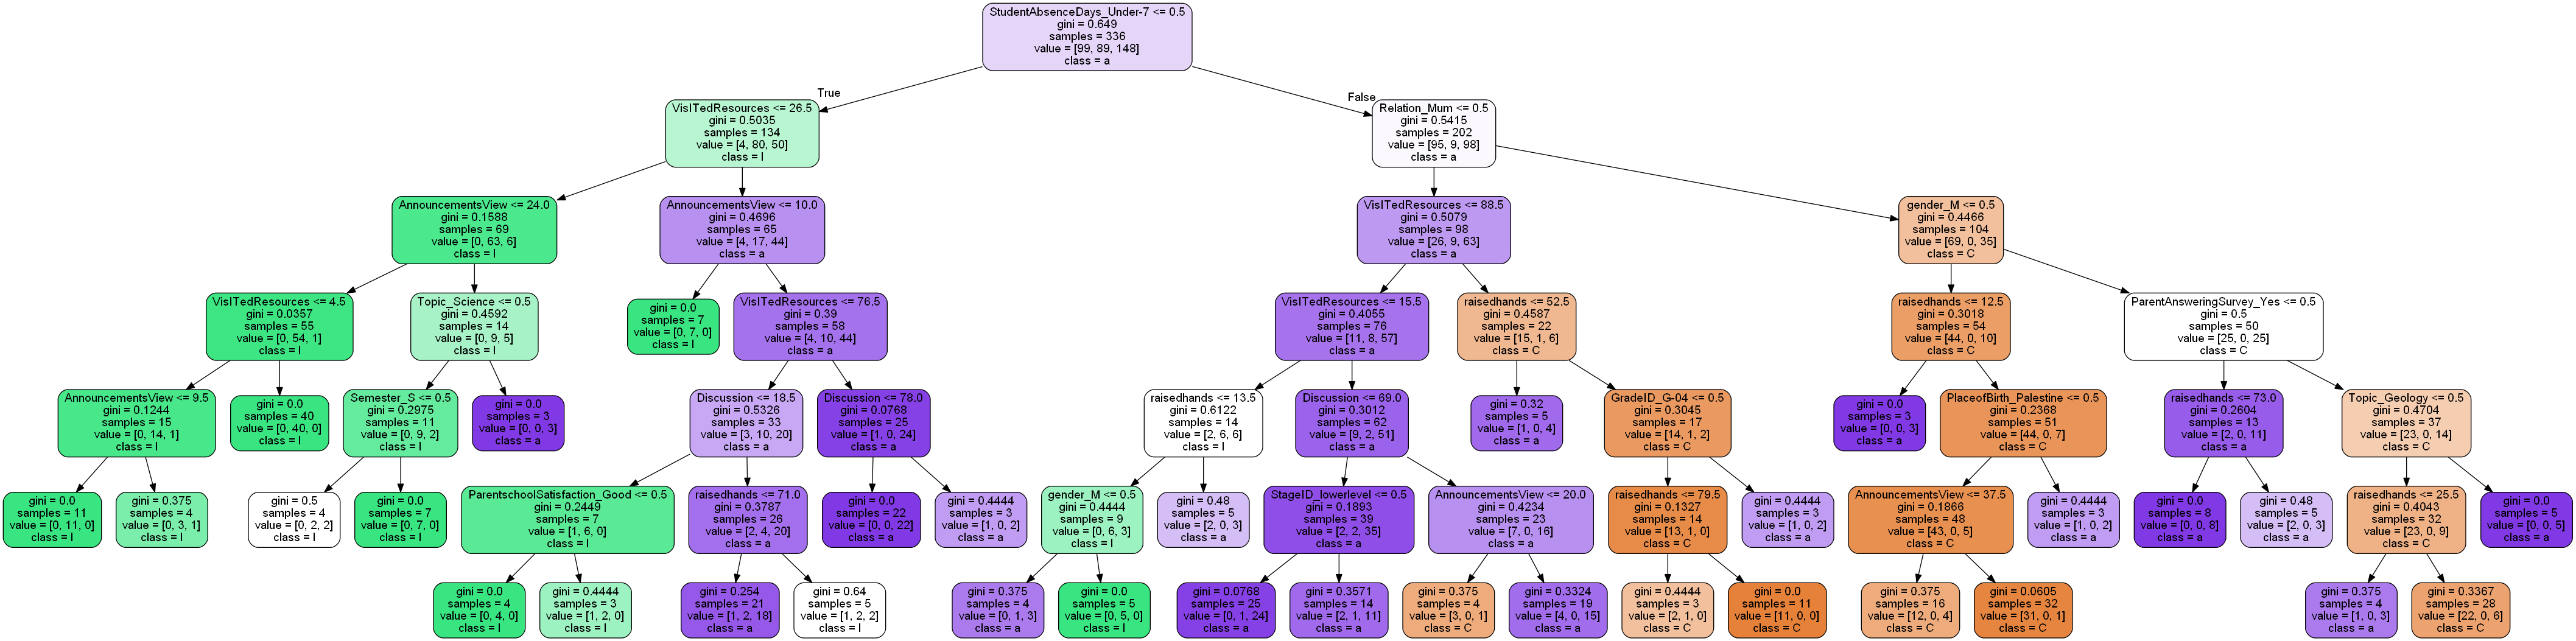

In [38]:
#pip install pydotplus
#conda install graphviz
#add to the PATH: C:\Users\username\Anaconda3\Library\bin\graphviz

from IPython.display import Image  
from sklearn import tree
import pydotplus 

dtc = DecisionTreeClassifier(max_depth= 6, min_samples_leaf = 3)
dtc.fit(x_train_strat, y_train_strat)
    
dot_data = tree.export_graphviz(dtc, out_file=None, 
                         feature_names=x.columns,
                         class_names=y.name,  
                         filled=True, rounded=True)  

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Заключение

Обе модели показали хорошие результаты:

In [41]:
svc = Pipeline([
    ('std', StandardScaler()),
    ('svc', SVC(kernel = 'linear', C=0.02))
])
svc.fit(x_train_raw, y_train_raw)
svc_score = accuracy_score(y_test_raw, svc.predict(x_test_raw))
print('SVC Score:', svc_score)

dtc = DecisionTreeClassifier(max_depth= 6, min_samples_leaf = 3)
dtc.fit(x_train_strat, y_train_strat)
tree_score = accuracy_score(y_test_strat, dtc.predict(x_test_strat))
print('Tree Score:', tree_score)

SVC Score: 0.736111111111
Tree Score: 0.798611111111


Но Древо показало результат лучше.